# Lab: Dimensionality and Numerosity Reduction

First, let's import all the libraries we'll need

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('BankChurners.csv')
print('Data shape:', df.shape)
df.head()

Data shape: (10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


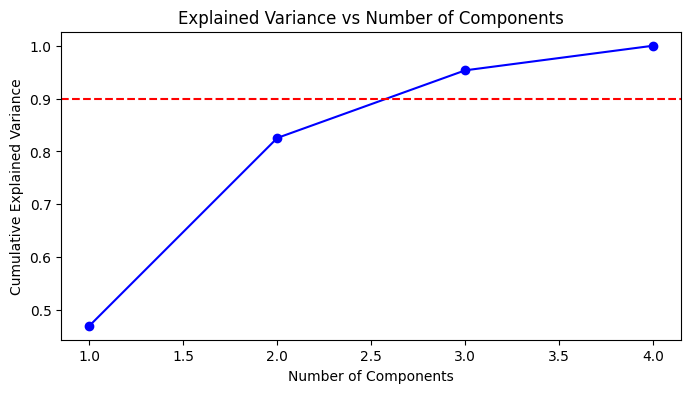


Explained variance by each component:
PC1: 0.470 (0.470 cumulative)
PC2: 0.355 (0.826 cumulative)
PC3: 0.128 (0.953 cumulative)
PC4: 0.047 (1.000 cumulative)


In [2]:
# lets do task A first - gonna apply PCA and tSNE
# first need to prepare the numeric data

numeric_cols = ['Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio']
X = df[numeric_cols]

# standardize the data cuz its needed for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# now lets do PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# see how much variance each component explains
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

# plot to see how many components we need
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, 'bo-')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.show()

print("\nExplained variance by each component:")
for i, var in enumerate(explained_var_ratio):
    print(f"PC{i+1}: {var:.3f} ({cumulative_var_ratio[i]:.3f} cumulative)")

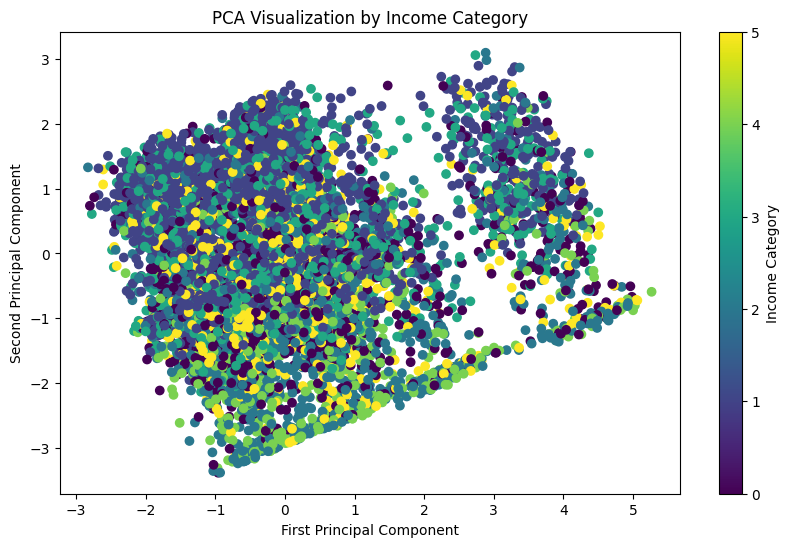

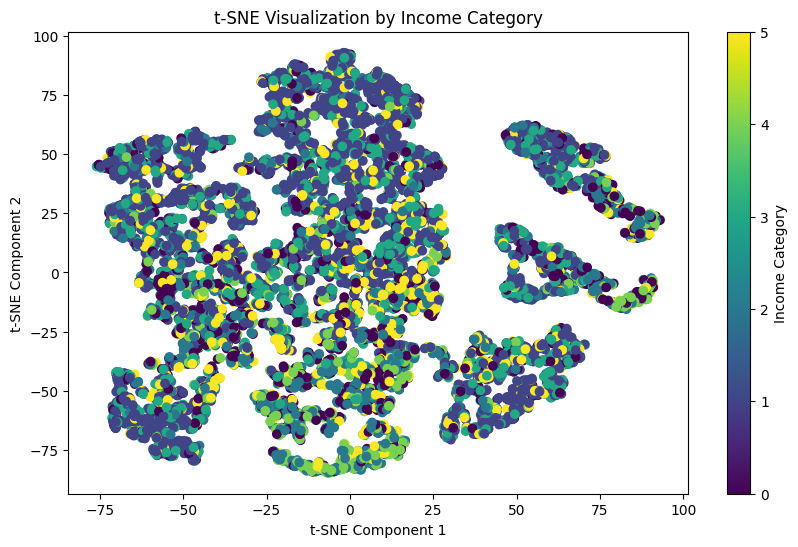


Principal Component Loadings:
     Credit_Limit  Total_Trans_Amt  Total_Trans_Ct  Avg_Utilization_Ratio
PC1      0.311854         0.666128        0.636638              -0.231758
PC2     -0.625979         0.223111        0.319151               0.675658


In [3]:
# now lets visualize in 2D using PCA and color by Income_Category
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                     c=pd.factorize(df['Income_Category'])[0], 
                     cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Visualization by Income Category')
plt.colorbar(scatter, label='Income Category')
plt.show()

# lets try t-SNE now - might take a bit to run
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     c=pd.factorize(df['Income_Category'])[0], 
                     cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization by Income Category')
plt.colorbar(scatter, label='Income Category')
plt.show()

# quick interpretation of what PC1 and PC2 mean
component_df = pd.DataFrame(
    pca_2d.components_,
    columns=numeric_cols,
    index=['PC1', 'PC2']
)
print("\nPrincipal Component Loadings:")
print(component_df)

In [4]:
# Task B - lets do some sampling stuff

# first get the baseline stats from full dataset
full_mean_credit = df['Credit_Limit'].mean()
full_mean_trans = df['Total_Trans_Amt'].mean()

print("Full Dataset Stats:")
print(f"Mean Credit Limit: ${full_mean_credit:,.2f}")
print(f"Mean Transaction Amount: ${full_mean_trans:,.2f}")

# simple random sampling with different sizes
def check_sample_error(sample_size_pct):
    sample_size = int(len(df) * sample_size_pct)
    sample = df.sample(n=sample_size, random_state=42)
    
    credit_error = abs(sample['Credit_Limit'].mean() - full_mean_credit) / full_mean_credit * 100
    trans_error = abs(sample['Total_Trans_Amt'].mean() - full_mean_trans) / full_mean_trans * 100
    
    return credit_error, trans_error

# try 5% and 10% samples
for pct in [0.05, 0.10]:
    credit_err, trans_err = check_sample_error(pct)
    print(f"\n{pct*100}% Sample Results:")
    print(f"Credit Limit Error: {credit_err:.2f}%")
    print(f"Transaction Amount Error: {trans_err:.2f}%")

# now lets try stratified sampling
def stratified_sample(df, strat_col, size_pct):
    groups = df.groupby(strat_col)
    sampled = pd.DataFrame()
    
    for name, group in groups:
        sample_size = int(len(group) * size_pct)
        sample = group.sample(n=sample_size, random_state=42)
        sampled = pd.concat([sampled, sample])
    
    return sampled

# do stratified sampling by Income_Category
strat_sample_10pct = stratified_sample(df, 'Income_Category', 0.10)

# compare results
strat_credit_error = abs(strat_sample_10pct['Credit_Limit'].mean() - full_mean_credit) / full_mean_credit * 100
strat_trans_error = abs(strat_sample_10pct['Total_Trans_Amt'].mean() - full_mean_trans) / full_mean_trans * 100

print("\nStratified Sampling Results (10%):")
print(f"Credit Limit Error: {strat_credit_error:.2f}%")
print(f"Transaction Amount Error: {strat_trans_error:.2f}%")

Full Dataset Stats:
Mean Credit Limit: $8,631.95
Mean Transaction Amount: $4,404.09

5.0% Sample Results:
Credit Limit Error: 11.53%
Transaction Amount Error: 0.80%

10.0% Sample Results:
Credit Limit Error: 1.53%
Transaction Amount Error: 1.79%

Stratified Sampling Results (10%):
Credit Limit Error: 7.06%
Transaction Amount Error: 5.38%


Cluster Centroids (Original Scale):
   Total_Trans_Amt  Total_Trans_Ct  Avg_Utilization_Ratio
0      1909.805012       39.285616               0.133691
1      3739.613503       65.694798               0.648227
2      4803.758815       75.377997               0.105680
3     14558.090078      110.258486               0.180111


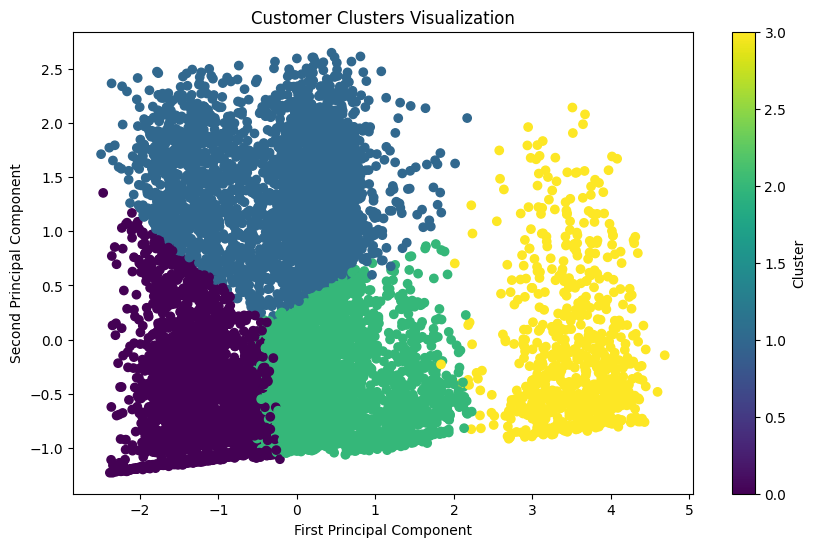


Average Metrics by Cluster:
         Credit_Limit  Total_Revolving_Bal
Cluster                                   
0        10070.508170           932.192928
1         2636.653579          1678.613214
2        11188.981225           885.005929
3        14082.138381          1367.622715


In [5]:
# Task C - lets do some clustering!

# pick features for clustering
cluster_features = ['Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio']
X_cluster = df[cluster_features]

# scale the data
X_cluster_scaled = StandardScaler().fit_transform(X_cluster)

# apply kmeans
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_cluster_scaled)

# look at the centroids
centroids_scaled = kmeans.cluster_centers_
centroids = pd.DataFrame(
    StandardScaler().fit(X_cluster).inverse_transform(centroids_scaled),
    columns=cluster_features
)

print("Cluster Centroids (Original Scale):")
print(centroids)

# visualize clusters using PCA
pca_cluster = PCA(n_components=2)
X_cluster_pca = pca_cluster.fit_transform(X_cluster_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_cluster_pca[:, 0], X_cluster_pca[:, 1], 
                     c=clusters, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Customer Clusters Visualization')
plt.colorbar(scatter, label='Cluster')
plt.show()

# compare credit limit and revolving balance across clusters
df['Cluster'] = clusters
print("\nAverage Metrics by Cluster:")
print(df.groupby('Cluster')[['Credit_Limit', 'Total_Revolving_Bal']].mean())

Cluster Centroids (Original Scale):
   Total_Trans_Amt  Total_Trans_Ct  Avg_Utilization_Ratio
0      1909.805012       39.285616               0.133691
1      3739.613503       65.694798               0.648227
2      4803.758815       75.377997               0.105680
3     14558.090078      110.258486               0.180111


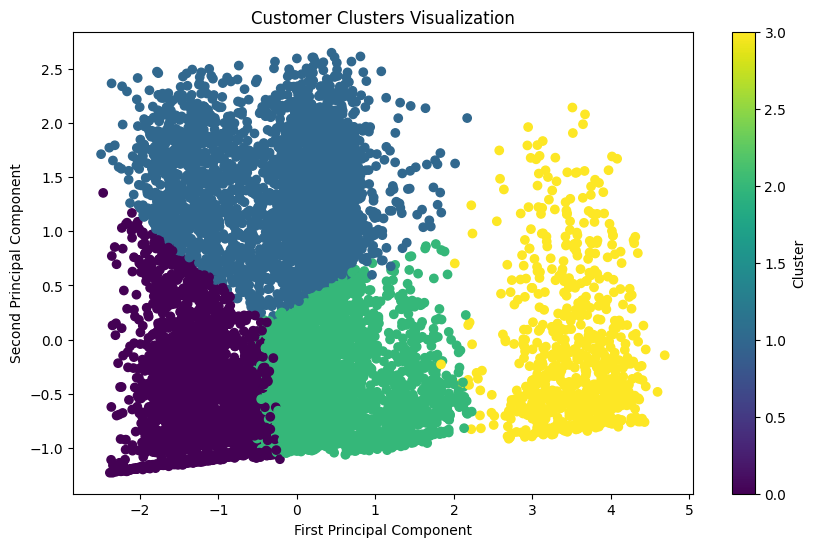


Average Metrics by Cluster:
         Credit_Limit  Total_Revolving_Bal
Cluster                                   
0        10070.508170           932.192928
1         2636.653579          1678.613214
2        11188.981225           885.005929
3        14082.138381          1367.622715


In [6]:
# Task C - lets do some clustering!

# pick features for clustering
cluster_features = ['Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio']
X_cluster = df[cluster_features]

# scale the data
X_cluster_scaled = StandardScaler().fit_transform(X_cluster)

# apply kmeans
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_cluster_scaled)

# look at the centroids
centroids_scaled = kmeans.cluster_centers_
centroids = pd.DataFrame(
    StandardScaler().fit(X_cluster).inverse_transform(centroids_scaled),
    columns=cluster_features
)

print("Cluster Centroids (Original Scale):")
print(centroids)

# visualize clusters using PCA
pca_cluster = PCA(n_components=2)
X_cluster_pca = pca_cluster.fit_transform(X_cluster_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_cluster_pca[:, 0], X_cluster_pca[:, 1], 
                     c=clusters, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Customer Clusters Visualization')
plt.colorbar(scatter, label='Cluster')
plt.show()

# compare credit limit and revolving balance across clusters
df['Cluster'] = clusters
print("\nAverage Metrics by Cluster:")
print(df.groupby('Cluster')[['Credit_Limit', 'Total_Revolving_Bal']].mean())